# GMM-based Speaker Recognition

In [10]:
import os
from matplotlib import pyplot as plt, cm
import pandas as pd
import numpy as np
import scipy as sp
# import seaborn as sns
%matplotlib inline
# print(plt.style.available)
# plt.style.use('seaborn-pastel')
plt.style.use('seaborn-notebook')
# plt.style.use('ggplot')
from scikits.audiolab import wavread
from scikits.talkbox.features import mfcc

## Data

- example database of 4 male speakers 15 sentences * 8 emotions = 120 wav files (~5s /per file) per speaker

In [11]:
rootdir = 'Savee'

sound_names = []
labels = []

for dirpath, dirname, files in os.walk(rootdir):
    for f in files:
        if f.endswith('.wav'):
            sound_names.append(os.path.join(dirpath,f))
            labels.append(dirpath.split('/')[1])
print sound_names[:5], labels[:5]
print len(sound_names)
! find Savee/ -name *.wav|wc -l

['Savee/DC/a01.wav', 'Savee/DC/a02.wav', 'Savee/DC/a03.wav', 'Savee/DC/a04.wav', 'Savee/DC/a05.wav'] ['DC', 'DC', 'DC', 'DC', 'DC']
480
     480


In [12]:
data = []
target = []
number_of_sounds = 480
for i in range(1, number_of_sounds + 1):
    rand_int = np.random.randint(0,len(sound_names))
    sound_name = sound_names[rand_int]
    label = labels[rand_int]
    try:
        snd = wavread(sound_name)
    except:
        continue
    data.append(snd)
    target.append(label)

In [13]:
print data[0], target[0]

(array([ 0.00131226,  0.00131226,  0.00128174, ...,  0.00131226,
        0.00128174,  0.00134277]), 44100, 'pcm16') KL


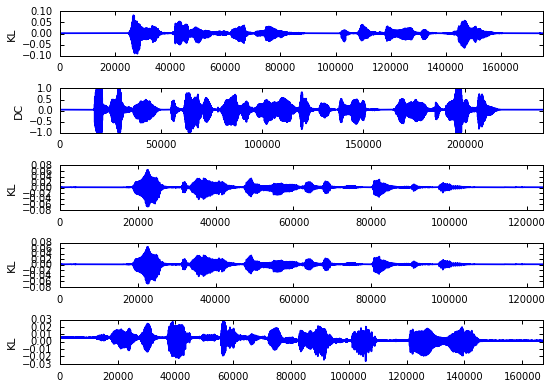

In [14]:
data = np.array(data)
target = np.array(target)

def plot_sounds(data_set, labels):
    i = 1
    plt.title("Example of sentence")
    for snd, label in zip(data_set,labels):
        plt.subplot(len(data_set),1,i)
        plt.plot(snd[0])
        plt.ylabel(label)
        plt.tight_layout()
        plt.xlim([0,len(snd[0])])
        i += 1

plot_sounds(data[:5], target[:5])

## Feature extraction

- compute stft (could use numpy rfft instead)

In [15]:
from scipy.signal import hann

def dft_np(signal, hop_size=256, fft_size=512):
    n_hops = len(signal) // hop_size
    s = []
    hann_win = hann(fft_size)
    for hop_i in range(n_hops):
        frame = signal[(hop_i * hop_size):(hop_i * hop_size + fft_size)]
        frame = np.pad(frame, (0, fft_size - len(frame)), 'constant')
        frame *= hann_win
        s.append(frame)
    s = np.array(s)
    N = s.shape[-1]
    k = np.reshape(np.linspace(0.0, 2 * np.pi / N * (N // 2), N // 2), [1, N // 2])
    x = np.reshape(np.linspace(0.0, N - 1, N), [N, 1])
    freqs = np.dot(x, k)
    reals = np.dot(s, np.cos(freqs)) * (2.0 / N)
    imags = np.dot(s, np.sin(freqs)) * (2.0 / N)
    return reals, imags

def ztoc(re, im):
    return np.sqrt(re**2 + im**2), np.angle(re + im * 1j)

def ctoz(mag, phs):
    return mag * np.cos(phs), mag * np.sin(phs)

- average STFT coefficient over frames to get 256 values/file (very crude approximation)

In [16]:
fft_size = 512
hop_size = 256

def compute_features(data_set, hop_size, fft_size):
    X = []
    for snd in data_set:
        re, im = dft_np(snd[0], hop_size=hop_size, fft_size=fft_size)
        mag, phs = ztoc(re, im)
#         np.log(mag.T)
        # average fft coefs over all frames to give 256 values per track
        m = np.mean(mag,axis=0)
        X.append(m)
    return np.array(X)

X = compute_features(data, hop_size, fft_size)

- X is an array of feature vectors. Each row is a speaker for a specific sentence

256


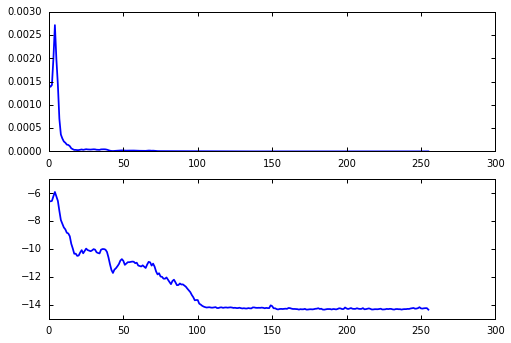

In [17]:
print len(X[0])
f,axes = plt.subplots(2)
axes[0].plot(X[0])
axes[1].plot(np.log(X[0]))

## Preprocessing

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture

mean: 3.70074341542e-18 std: 1.0


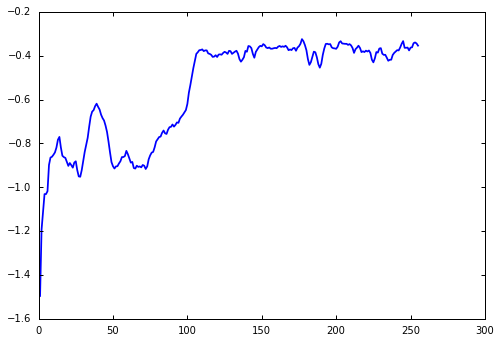

In [19]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)
y = target
plt.plot(X_scaled[0])
print "mean: {} std: {}".format(X_scaled.mean(), X_scaled.std())

## Split data into test and train set

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33)
print "unique classes: ", np.unique(target)
print "number of classes:", len(np.unique(target))
print "size of training and testing sets:", len(X_train), len(X_test)

unique classes:  ['DC' 'JE' 'JK' 'KL']
number of classes: 4
size of training and testing sets: 321 159


- we group all the training instances from the same speaker in a hash

In [24]:
speakers = {}
for label in ['DC', 'JE', 'JK', 'KL']:
    speakers[label] = X_train[y_train == label]

for k in speakers:
    print "speaker: ", k, np.shape(speakers[k])

speaker:  JE (78, 256)
speaker:  KL (79, 256)
speaker:  DC (76, 256)
speaker:  JK (88, 256)


## Train GMM

- we train one gaussian mixture model per user

In [26]:
gmms ={}
for speaker in ['DC', 'JE', 'JK', 'KL']:
    gmms[speaker] = GaussianMixture(32)
    gmms[speaker].fit(speakers[speaker])

## Prediction

In [84]:
gmms['DC'].score(X_train[0].reshape(1,-1))

-250459.24835030461

- to predict we compute the score of the present 

In [27]:
def predict(X):
    max_score = None
    max_key = None
    for key, value in gmms.iteritems():
        score = gmms[key].score(X.reshape(1,-1))
        if score > max_score:
            max_score = score
            max_key = key
    return max_key, max_score

def accuracy(X_test, y_test):
    count = 0
    for i in range(len(X_test)):
        p = predict(X_test[i])
        if p[0] == y_test[i]:
            count += 1
    return count/float(len(X_test))

print predict(X_test[0]), y_test[0]
print "accuracy:", accuracy(X_test, y_test)


('KL', 1530.1539334276838) KL
accuracy: 0.918238993711


- For more advanced large scale speaker identification I highly recommend Bob spear framework (https://pythonhosted.org/bob.bio.spear/)